In [30]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.initializers import glorot_uniform  # Or your initializer of choice
from keras.datasets import mnist
import keras.backend as K
from keras.callbacks import TensorBoard

import numpy as np
import random
import mir_utils as miru
import sounddevice as sd

sr=40000 #sample rate
input_dim=5000
group_size=100
# this is the size of our encoded representations
encoding_dim = 100  #floats -> compression factor of input_dim/encoding_dim

# this is our input placeholder
input_sample= Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_sample)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_sample, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_sample, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [31]:
#takes an audio dict, desired length of samples and split percentage of test & train subsets
#returns x_train,x_test,y_train,y_test
def audioDictToNp(group_size=10,dur=10000,testFraction=0):
    a=miru.loadAudioArrays()
    X=[]
    y=[]
    for key,l in a.items():
            for i in l:
                if len(i)>dur and key!="asdfkick":
                    y.append(key)
                    X.append(i[0:dur])
    X=np.asarray(X)
    y=np.asarray(y)
    if testFraction==0:
        return X,X,y,y
    else:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFraction, random_state=42)
        return X_train, X_test, y_train, y_test
            
x_train, x_test, y_train, y_test=audioDictToNp(group_size=group_size,dur=input_dim,testFraction=0.1)

print("train,test shapes:",x_train.shape,x_test.shape)

train,test shapes: (2045, 5000) (228, 5000)


In [32]:
def train():
    initial_weights = autoencoder.get_weights()
    k_eval = lambda placeholder: placeholder.eval(session=K.get_session())
    new_weights = [k_eval(glorot_uniform()(w.shape)) for w in initial_weights]
    
    weights = [k_eval(glorot_uniform()(w.shape)) for w in initial_weights]
#     autoencoder.set_weights(weights)
    
    autoencoder.fit(x_train, x_train,
                    epochs=100,
                    batch_size=10,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1,
                    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
                   )
train()

# encode and decode some digits
# note that we take them from the *test* set
encoded_samples = encoder.predict(x_test)
decoded_samples = decoder.predict(encoded_samples)
print(autoencoder.summary())

Train on 2045 samples, validate on 228 samples
Epoch 1/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0736 - val_loss: 0.0755
Epoch 2/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0722 - val_loss: 0.0748
Epoch 3/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0714 - val_loss: 0.0740
Epoch 4/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0703 - val_loss: 0.0728
Epoch 5/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0687 - val_loss: 0.0711
Epoch 6/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0666 - val_loss: 0.0692
Epoch 7/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0644 - val_loss: 0.0672
Epoch 8/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0623 - val_loss: 0.0651
Epoch 9/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0601 - val_loss: 0.0629
Epoch 10/100
2045/2045 [==

2045/2045 [==============================] - 4s 2ms/step - loss: 0.0221 - val_loss: 0.0273
Epoch 80/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0220 - val_loss: 0.0273
Epoch 81/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0219 - val_loss: 0.0272
Epoch 82/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0218 - val_loss: 0.0271
Epoch 83/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0217 - val_loss: 0.0270
Epoch 84/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0216 - val_loss: 0.0269
Epoch 85/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0215 - val_loss: 0.0268
Epoch 86/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0214 - val_loss: 0.0267
Epoch 87/100
2045/2045 [==============================] - 4s 2ms/step - loss: 0.0213 - val_loss: 0.0267
Epoch 88/100
2045/2045 [==============================] - 4s 2ms/step - loss:

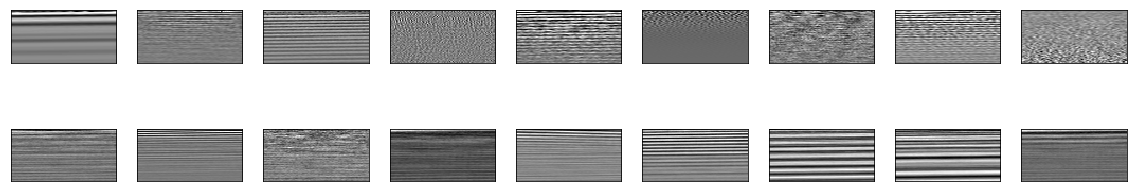

In [25]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

n = 9 # how many samples we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(50, int(input_dim/50)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_samples[i].reshape(50, int(input_dim/50)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
from IPython.display import Audio, display
from ipywidgets import widgets

original_widgets = []
for (audio) in x_train[0:10]:
    out = widgets.Output()
    with out:
        display(Audio(data=audio, rate=sr))
    original_widgets.append(out)
oBox=widgets.HBox(original_widgets)


decoded_widgets = []
for (audio) in decoded_samples[0:10]:
    out = widgets.Output()
    with out:
        display(Audio(data=audio, rate=sr))
    decoded_widgets.append(out)
dBox=widgets.HBox(decoded_widgets)

widgets.VBox([oBox,dBox])
